### Дано
Топ-менеджеры компании узнали от коллег индустрии, насколько круто работает динамическое ценообразование, и решили тоже провести такой эксперимент. Иными словами, они поставили себе задачу сделать такой модуль на основе машинного обучения, который бы показывал разным пользователям разные цены на одни и те же товары с целью увеличения среднего чека. Наняли команду data science специалистов, которая разработала алгоритм и провела А/B-тестирование.

### Задача
Ваша задача — помочь менеджерам сделать вывод об успешности эксперимента и дать максимальное количество данных для принятия решения о том, стоит ли дальше развивать алгоритм и сколько ресурсов можно на это выделить.

In [1]:
import pandas as pd
import numpy as np

Изучаем данные

In [2]:
df = pd.read_csv('ecom_data.csv')

Описание колонок:
- InvoiceNo — идентификатор чека.
- StockCode — идентификатор товара.
- Description — описание товара.
- Quantity — количество товара в чеке.
- InvoiceDate — дата покупки.
- UnitPrice — стоимость товара в чеке.
- CustomerID — идентификатор пользователя.
- Country — страна.

In [3]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,GroupType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,control
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,control
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,control
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,control
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,control
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,control
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,control
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,control
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,control


In [4]:
df.CustomerID.nunique()

4372

Изучаем ключевые метрики:
Так как мы будем сравнивать средний чек, давайте посмотрим на его расперделение

<Axes: >

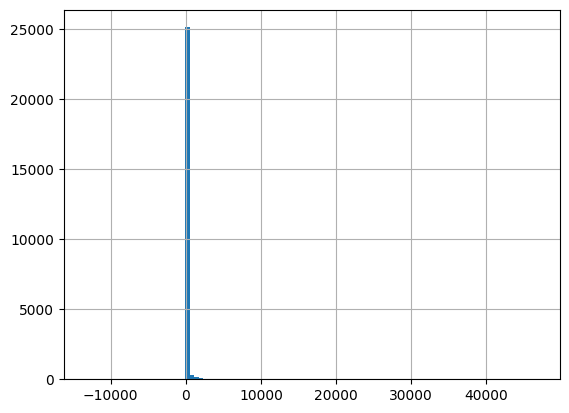

In [5]:
df.groupby('InvoiceNo').UnitPrice.sum().hist(bins=100)

Как и предполагалось, оно не очень похоже на нормальное. Дополнительно можно заметить, что тут присутствуют отрицательные значения — это возвраты товаров. Давайте их удалим:

<Axes: >

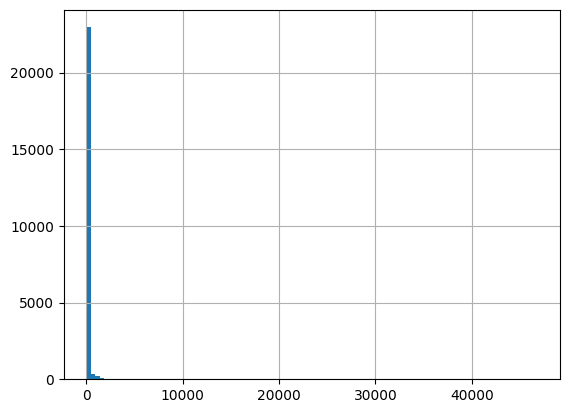

In [6]:
df = df[df['UnitPrice'] > 0]
df.groupby('InvoiceNo').UnitPrice.sum().hist(bins=100)

Так уже лучше! Теперь мы можем протестировать разные подходы с трансформацией данных.

_______

#### Логарифмирование данных

Тестирование подхода с логарифмированием
Начнём с самого простого — с логарифмирования. Для этого можем сначала посмотреть, как выглядит трансформированное распределение

In [7]:
from matplotlib import pyplot

In [8]:
long_means_bills = df.groupby('InvoiceNo').UnitPrice.sum().apply(lambda x: np.log(x)).values.tolist()

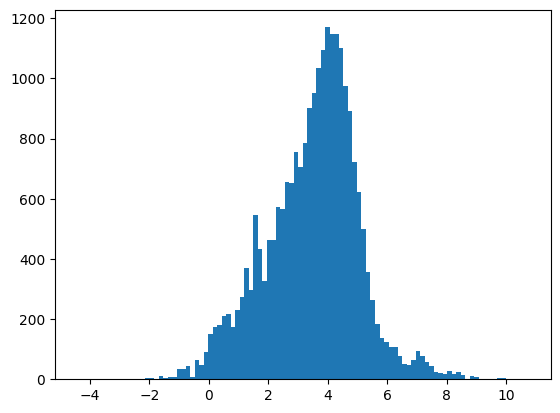

In [9]:
pyplot.hist(long_means_bills, bins=100)
pyplot.show()

Тоже не очень похоже на нормальное, но давайте на всякий случай проверим с помощью теста Шапиро-Уилка:

In [10]:
from scipy.stats import shapiro

stat, p_val = shapiro(long_means_bills)
print(f'p-value: {p_val}')

p-value: 3.2127012716125045e-42


/Users/erikbagdasarov/PycharmProjects/Traning/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23796.
  res = hypotest_fun_out(*samples, **kwds)


Действительно, p-value сильно ниже 0.05, поэтому логарифмирование не помогло.

_______

#### Бокс-Кокс Тестирование преобразования 

Применим более мощный способ с трансформацией Бокса-Кокса:

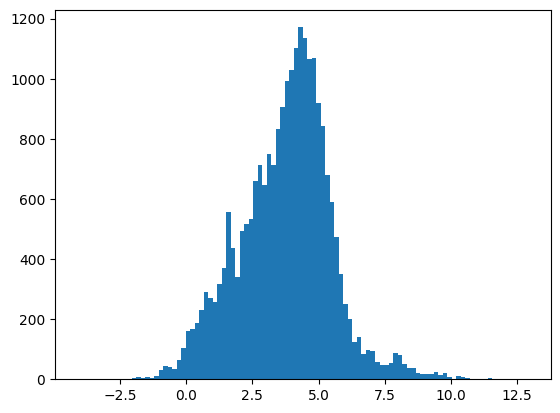

In [11]:
from scipy.stats import boxcox

boxcox_mean_bills, fitted_lambda = boxcox(df.groupby('InvoiceNo').UnitPrice.sum().values.tolist())

pyplot.hist(boxcox_mean_bills, bins=100)
pyplot.show()

In [12]:
stats, p_val = shapiro(boxcox_mean_bills)
print(f'p-value: {p_val}')

p-value: 6.8293153946766e-41


/Users/erikbagdasarov/PycharmProjects/Traning/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23796.
  res = hypotest_fun_out(*samples, **kwds)


p-value немного выросло, но недостаточно, чтобы мы могли назвать такое распределение нормальным.

_______

#### Бутстрэп-сэмплирования

Тогда проверим гипотезу о разности среднего чека по группам через бутстрэп-сэмплирование:

In [13]:
from tqdm.notebook import tqdm

ModuleNotFoundError: No module named 'tqdm'

Создалим списки с отфильтрованными данными по группам

In [ ]:
control_values = df[df['GroupType'] == 'control'].groupby('InvoiceNo').UnitPrice.sum().values.tolist()
test_values = df[df['GroupType'] == 'test'].groupby('InvoiceNo').UnitPrice.sum().values.tolist()

Применяем bootstrap-сэмплирование

In [ ]:
sample_mean_control = []
sample_mean_test = []

for i in tqdm(range(10000)):
    sample_n = np.random.choice(control_values, size=300)
    sample_mean_control.append(sample_n.mean())

    sample_n = np.random.choice(test_values, size=300)
    sample_mean_test.append(sample_n.mean())

Посмотрим на получившиеся распределения

In [ ]:
pyplot.hist(sample_mean_control, bins=100, alpha=0.7)
pyplot.hist(sample_mean_test, bins=100, alpha=0.7)
pyplot.show()

Заметно, что распределения разные, и тестовое явно находится правее контрольного. То есть матожидание точно выше.

Давайте посмотрим на квантили по каждому из распределений и узнать, является ли разница статистически значимой. Для этого обратим внимание на 95 перцентиль у контрольной группы (рыжая на графике) и 5 перцентиль у тестовой группы (синяя на графике). Если первое значение будет меньше второго, значит, пересечение этих распределений меньше 5% и разность между ними статистически значимая.

In [ ]:
print(f'Control 95% precentile: {np.percentile(sample_mean_control, 95)}')
print(f'Test 5% precentile: {np.percentile(sample_mean_test, 5)}')

Действительно, 95 перцентиль контрольного распределения меньше, чем 5 перцентиль тестового. Следовательно, мы можем отвергнуть нулевую гипотезу о том, что средний чек между группами равен. Поэтому наш эксперимент можно считать успешным!

_______

#### Построение доверительного интервала с помощью бутстрэп-сэмплирования

И так эксперемент успешен и теперь можно просчитать, на какой прирост стоит рассчитывать после применения динамического цеообразования для всей аудитории. 

Это в дальнейшем позволит менеджерам оценить экономическую эффективность разработки и потенциальные решения о выделении дополнительных ресурсов на улучшение алгоритмов ценообразования.

Для этого нам необходимо рассчитать доверительный интервал прироста среднего чека на покупателя. И это мы тоже можем сделать с помощью бутстрэп-сэмплирования. Проводим ровно ту же операцию 10000 раз, только теперь записываем отношение среднего на каждом шаге сэмплирования.

In [ ]:
sample_mean_ratio = []

for i in tqdm(range(10000)):
    sample_test = np.random.choice(test_values, size=300)
    sample_control = np.random.choice(control_values, size=300)

    sample_mean_ratio.append(sample_test.mean() / sample_control.mean())

Далее увидим следующий график

In [ ]:
pyplot.hist(sample_mean_ratio, bins=100)
pyplot.show()

Это распределение вероятности прироста среднего чека. Давайте теперь вычислим доверительный интервал. Для это просто возьмем 2.5 и 97.5 процентили:

In [ ]:
print(np.percentile(sample_mean_ratio, 2.5), np.percentile(sample_mean_ratio, 97.5))

В этих значениях лежит реальный прирост среднего чека при масштабировании эксперимента на всю аудиторию.